In [1]:
import pandas as pd

import seaborn as sns
import numpy as np

# STEP 1: READING AND PROCESSING DATA
Dataset used: https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset

In [2]:
dataset = pd.read_csv("./data/crop.rec.csv")
dataset

,N,P,K,temperature,humidity,ph,rainfall,label,season
0,90,42,43,20.879744,82.002744,6.502985,202.935536,Rice,Kharif
1,85,58,41,21.770462,80.319644,7.038096,226.655537,Rice,Kharif
2,60,55,44,23.004459,82.320763,7.840207,263.964248,Rice,Kharif
3,74,35,40,26.491096,80.158363,6.980401,242.864034,Rice,Kharif
4,78,42,42,20.130175,81.604873,7.628473,262.717340,Rice,Kharif
...,...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee,Rabi
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee,Kharif
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee,Rabi
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee,Kharif


In [3]:
dataset.isna().sum().sum()

0

There are no null values!

In [4]:
labels_unique = list(set(dataset["label"]))
labels_unique

['lentil',
 'cotton',
 'mungbean',
 'coffee',
 'mango',
 'coconut',
 'pomegranate',
 'mothbeans',
 'chickpea',
 'jute',
 'blackgram',
 'watermelon',
 'kidneybeans',
 'banana',
 'Rice',
 'grapes',
 'muskmelon',
 'Maize',
 'orange',
 'pigeonpeas',
 'apple',
 'papaya']

In [5]:
dataset["label"] = dataset["label"].map(lambda x: labels_unique.index(x))

In [6]:
seasons = ["Rabi", "Kharif"]
dataset["season"] = dataset["season"].map(lambda x: seasons.index(x))

In [7]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

# STEP 2: FEATURE VISUALISATION/SELECTION

,count,mean,std,min,25%,50%,75%,max
N,1760.0,50.540341,36.779162,0.000000,21.000000,37.000000,84.000000,140.000000
P,1760.0,53.518182,33.252847,5.000000,28.000000,51.000000,68.000000,145.000000
K,1760.0,48.578977,51.173600,5.000000,20.000000,32.000000,49.000000,205.000000
temperature,1760.0,25.614251,5.077277,8.825675,22.780645,25.548603,28.636212,43.360515
humidity,1760.0,71.384936,22.405184,14.258040,60.231681,80.432472,90.015634,99.981876
ph,1760.0,6.464833,0.783890,3.504752,5.956308,6.422961,6.931730,9.935091
rainfall,1760.0,103.412477,55.220490,20.211267,64.509670,94.867624,124.704676,298.560117
label,1760.0,10.586932,6.316852,0.000000,5.000000,11.000000,16.000000,21.000000
season,1760.0,0.680682,0.466345,0.000000,0.000000,1.000000,1.000000,1.000000


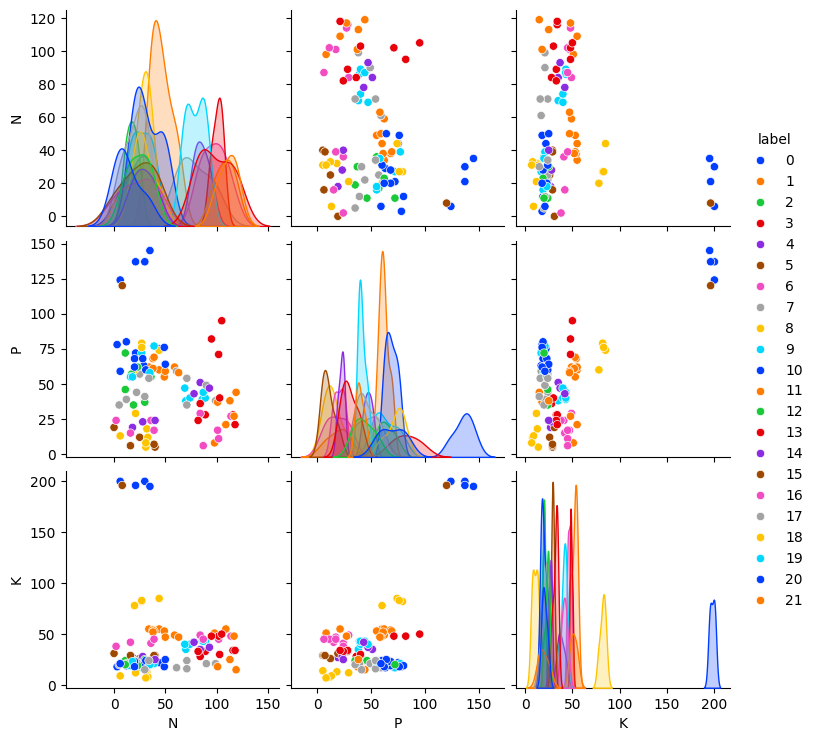

In [8]:
sample = dataset[["N", "P", "K", "label"]].sample(n=100, random_state=42)

sns.pairplot(
    sample,
    hue="label",
    palette="bright",
    # diag_kind="reg",
    # x_vars=["N", "P"],
    # y_vars=["K", "N"]
)


train_dataset.describe().transpose()

In [9]:
X_train = train_dataset.copy().drop("label", axis=1)
X_test = test_dataset.copy().drop("label", axis=1)

In [10]:
Y_train = train_dataset.copy()["label"]
Y_test = test_dataset.copy()["label"]

## Normalizing the Data

In [11]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# X_train

# STEP 3: MODEL SELECTION

In [12]:
### INITIALIZATION ###

from sklearn.metrics import multilabel_confusion_matrix
import time


def run_model(m, fit = True):
    begin = time.time()

    ret = {}
    if fit:
        m.fit(X_train, Y_train)
    ret["cnf"] = multilabel_confusion_matrix(Y_test, m.predict(X_test))
    ret["score"] = m.score(X_test, Y_test)
    ret["time"] = time.time() - begin

    return ret

# 3.1 TESTING VARIOUS CLASSIFICATION MODELS

In [13]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

clf_models = [
    SVC(random_state=42, class_weight="balanced", gamma=1000, break_ties=True, max_iter=120, kernel="linear", C=0.005),
    RandomForestClassifier(random_state=42, max_depth=10, max_samples=100, max_features=3),
    KNeighborsClassifier(),
]

for model in clf_models:
    print(f"> testing model: {model.__class__.__name__}")
    scores = run_model(model)
    print(f"  accuracy:   {(scores['score'] * 100):.{3}}%")
    print(f"  time taken: {scores['time']:.{3}}s")
    print("  confusion matrix:")
    print(scores["cnf"].sum(axis=0))

> testing model: SVC
  accuracy:   99.5%
  time taken: 0.0537s
  confusion matrix:
[[9238    2]
 [   2  438]]
> testing model: RandomForestClassifier


/home/smv/code/fresh-fields/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=120).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


  accuracy:   99.3%
  time taken: 0.174s
  confusion matrix:
[[9237    3]
 [   3  437]]
> testing model: KNeighborsClassifier
  accuracy:   98.0%
  time taken: 0.0446s
  confusion matrix:
[[9231    9]
 [   9  431]]


In [14]:
# from sklearn.model_selection import GridSearchCV

# param_grid_svm = {
#     "gamma": [1, 0.2857, 0.1],
#     "kernel": ["linear", "rbf", "poly", "sigmoid"],
#     "class_weight": ["balanced"],
# }

# model = GridSearchCV(
#     SVC(random_state=42, probability=True),
#     param_grid=param_grid_svm,
#     verbose=2,
#     cv=8,
#     n_jobs=-1,
# )

# scores = model.fit(X_train, Y_train)

In [15]:
# scores.best_params_

In [16]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight("balanced", classes=np.unique(Y_train), y=Y_train)

In [17]:
svc_model = SVC(random_state=42, class_weight=dict(enumerate(class_weights)), gamma=1, kernel="linear", C=0.005, probability=True)
svc_model.fit(X_train, Y_train)

SVC(C=0.005,
    class_weight={0: 1.0256410256410255, 1: 1.0256410256410255,
                  2: 1.0666666666666667, 3: 1.0126582278481013,
                  4: 1.0666666666666667, 5: 1.0, 6: 1.0, 7: 0.9411764705882353,
                  8: 0.975609756097561, 9: 1.0666666666666667,
                  10: 0.975609756097561, 11: 0.9876543209876543,
                  12: 0.9523809523809523, 13: 1.0126582278481013,
                  14: 0.963855421686747, 15: 0.9876543209876543,
                  16: 0.9876543209876543, 17: 0.9876543209876543,
                  18: 1.0256410256410255, 19: 1.0126582278481013,
                  20: 0.963855421686747, 21: 0.9876543209876543},
    gamma=1, kernel='linear', probability=True, random_state=42)

In [18]:
scores = run_model(svc_model, False)
print(f"  accuracy:   {(scores['score'] * 100):.{3}}%")
print(f"  time taken: {scores['time']:.{3}}s")
print("  confusion matrix:")
print(scores["cnf"].sum(axis=0))

  accuracy:   99.3%
  time taken: 0.027s
  confusion matrix:
[[9237    3]
 [   3  437]]


In [19]:
from joblib import dump, load

dump(svc_model, "./out/crop.recommend.joblib")

['./out/crop.recommend.joblib']

In [20]:
clf = load("./out/crop.recommend.joblib")

scores = run_model(clf, False)
print(f"  accuracy:   {(scores['score'] * 100):.{3}}%")
print(f"  time taken: {scores['time']:.{3}}s")
print("  confusion matrix:")
print(scores["cnf"].sum(axis=0))

  accuracy:   99.3%
  time taken: 0.0193s
  confusion matrix:
[[9237    3]
 [   3  437]]
